但现在我们需要制作了一个新的csv：

```
date,temp,oxygen,NH3,TP,TN,algae,area,weather,max_temperature,min_temperature,aqi,aqiLevel,wind_direction,wind_power,aqiInfo
2021-06-02,26.1875,6.6665,0.025,0.068275,1.07325,14400000.0,无锡,阴-阵雨,26,21,24,1,东南风,4级,优
2021-06-03,25.881666666666664,6.6418333333333335,0.0251166666666666,0.0637833333333333,0.9151666666666666,10867091.666666666,无锡,阴-阵雨,26,19,66,2,西北风,3级,良
2021-06-04,25.895,7.946333333333333,0.025,0.0637833333333333,0.9203333333333332,25498423.33333333,无锡,阴-多云,26,18,51,2,西南风,3级,良
2021-06-05,26.85,9.084,0.025,0.04776,0.9058,21100000.0,无锡,晴,32,19,67,2,西南风,3级,良
2021-06-06,28.256666666666664,9.514333333333331,0.025,0.0440666666666666,0.9233333333333332,15211340.0,无锡,晴,33,19,80,2,南风,3级,良
2021-06-07,27.635,8.3865,0.025,0.0366499999999999,0.7778333333333333,7994458.333333333,无锡,阴-多云,35,21,68,2,东南风,3级,良
2021-06-08,28.19666666666667,8.397499999999999,0.025,0.0418666666666666,0.7323333333333334,12259158.333333334,无锡,阴-多云,30,24,36,1,东南风,3级,优
2021-06-09,28.751666666666665,8.309166666666668,0.025,0.0389833333333333,0.601,6891956.666666667,无锡,阴-雷阵雨,32,24,52,2,东南风,3级,良
2021-06-10,28.741666666666664,7.385833333333333,0.025,0.03785,0.5256666666666666,6301236.666666667,无锡,阴,28,24,38,1,东南风,2级,优
2021-06-11,29.491666666666664,7.6176666666666675,0.025,0.0327666666666666,0.4495,6244151.666666667,无锡,阴-多云,32,23,82,2,东风,2级,良
2021-06-12,29.58666666666667,7.271999999999999,0.025,0.02975,0.3741666666666667,4201731.666666667,无锡,多云-雷阵雨,33,24,41,1,东南风,3级,优
2021-06-13,29.563333333333333,6.929333333333333,0.025,0.0302833333333333,0.2663333333333333,4964940.0,无锡,阴-小雨,28,25,34,1,西南风,2级,优
2021-06-14,29.58833333333333,6.963166666666666,0.025,0.0290666666666666,0.1886666666666666,5394340.0,无锡,阴-小雨,31,25,46,1,东南风,3级,优
2021-06-15,30.21,7.23925,0.025,0.033425,0.396,6927237.5,无锡,阴-小雨,33,24,48,1,西南风,3级,优
```

这里我们要用Transformer预测藻类的爆发，来捕获时间序列数据的长距离依赖关系。

通过前期的数据分析，我们发现：
- 这里需要考虑weather这一列出现“晴”的影响，以及“晴”滞后0~4天的影响。
- 温度的影响，这里，只采用temp作为特征，考虑温度滞后10~20天的影响。
- 考虑max_temperature,min_temperature的差值，尤其需要考虑温差较大的情况。
- wind_power大于4级时是一个需要考虑的因素，滞后2~6天为负相关，滞后10~16天为正相关。
- 这里的aqi,aqiLevel，aqiInfo与空气质量相关，不考虑。
- wind_direction也不考虑。

请你输出完整的代码。

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. 数据加载和预处理
df = pd.read_csv('/root/Download/AlgaeBloomForecast/merged_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# 2. 特征工程
def create_features(df):
    # 天气特征
    df['is_sunny'] = df['weather'].str.contains('晴').astype(int)
    for i in range(1, 5):
        df[f'is_sunny_lag_{i}'] = df['is_sunny'].shift(i)
    
    # 温度特征
    for i in range(10, 21):
        df[f'temp_lag_{i}'] = df['temp'].shift(i)
    
    # 温差特征
    df['temp_diff'] = df['max_temperature'] - df['min_temperature']
    df['large_temp_diff'] = (df['temp_diff'] > df['temp_diff'].mean()).astype(int)
    
    # 风力特征
    df['high_wind'] = (df['wind_power'].str.extract('(\d+)').astype(float) > 4).astype(int)
    for i in range(2, 7):
        df[f'high_wind_lag_neg_{i}'] = df['high_wind'].shift(i)
    for i in range(10, 17):
        df[f'high_wind_lag_pos_{i}'] = df['high_wind'].shift(i)
    
    return df

df = create_features(df)

# 选择特征和目标变量
features = ['temp', 'oxygen', 'NH3', 'TP', 'TN', 'is_sunny'] + \
           [f'is_sunny_lag_{i}' for i in range(1, 5)] + \
           [f'temp_lag_{i}' for i in range(10, 21)] + \
           ['temp_diff', 'large_temp_diff'] + \
           [f'high_wind_lag_neg_{i}' for i in range(2, 7)] + \
           [f'high_wind_lag_pos_{i}' for i in range(10, 17)]

target = 'algae'

# 删除包含NaN的行
df = df.dropna(subset=features + [target])

# 归一化特征
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# 准备数据
X = df[features].values
y = df[target].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 创建PyTorch数据集和数据加载器
class AlgaeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = AlgaeDataset(X_train, y_train)
test_dataset = AlgaeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. 定义Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout),
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.transformer(x)
        x = x.squeeze(1)
        return self.fc(x)

# 5. 训练模型
input_dim = len(features)
hidden_dim = 64
num_layers = 2
num_heads = 4
dropout = 0.1

model = TransformerModel(input_dim, hidden_dim, num_layers, num_heads, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")

# 6. 评估模型
model.eval()
predictions = []
true_values = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X).squeeze()
        predictions.extend(outputs.numpy())
        true_values.extend(batch_y.numpy())

predictions = np.array(predictions)
true_values = np.array(true_values)

mse = np.mean((predictions - true_values) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - true_values))

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3018/3202208008.py:31: SyntaxWarning: invalid escape sequence '\d'
  df['high_wind'] = (df['wind_power'].str.extract('(\d+)').astype(float) > 4).astype(int)
/root/.conda/envs/hydro/envs/algae/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100, Train Loss: 1804784671809232.5000, Test Loss: 1388558761253741.7500
Epoch 2/100, Train Loss: 1801301041979695.5000, Test Loss: 1388558698938368.0000
Epoch 3/100, Train Loss: 1811532404703838.7500, Test Loss: 1388558612655542.7500
Epoch 4/100, Train Loss: 1797039740963802.0000, Test Loss: 1388558454470363.5000
Epoch 5/100, Train Loss: 1809066058259569.7500, Test Loss: 1388558301078674.2500
Epoch 6/100, Train Loss: 1801522154501764.7500, Test Loss: 1388558162067456.0000
Epoch 7/100, Train Loss: 1802844247590077.7500, Test Loss: 1388557927186432.0000
Epoch 8/100, Train Loss: 1794782221148463.5000, Test Loss: 1388557687511917.7500
Epoch 9/100, Train Loss: 1802360459789501.7500, Test Loss: 1388557514946267.5000
Epoch 10/100, Train Loss: 1798289715635693.0000, Test Loss: 1388557184195437.7500
Epoch 11/100, Train Loss: 1795589923551459.5000, Test Loss: 1388556920553472.0000
Epoch 12/100, Train Loss: 1798498292470518.5000, Test Loss: 1388556513106797.7500
Epoch 13/100, Train Loss:

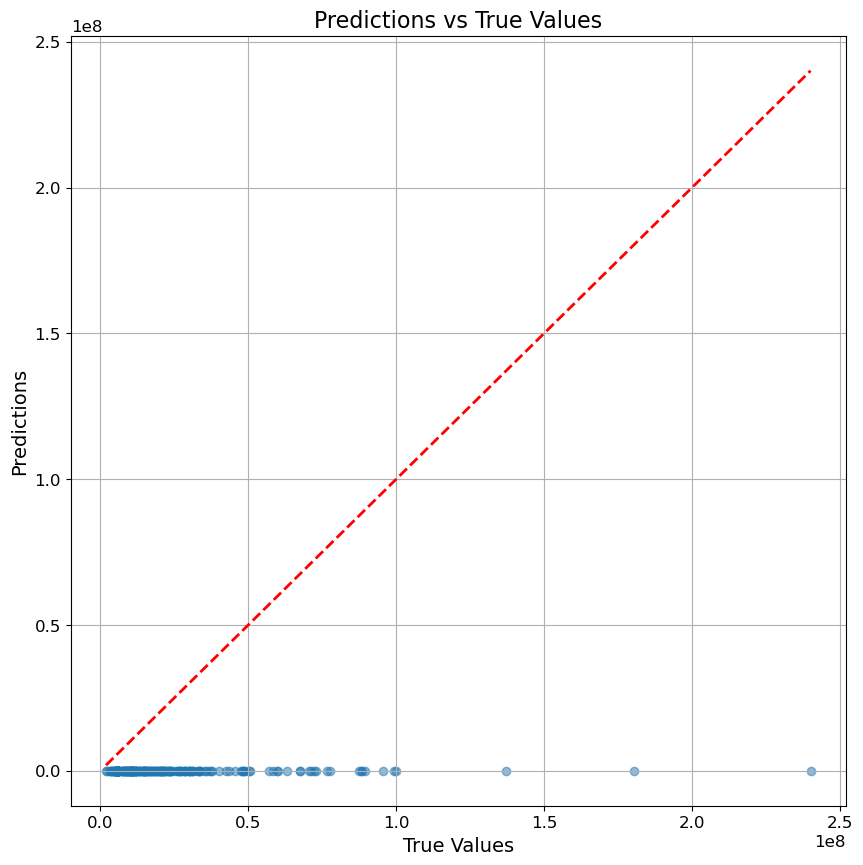

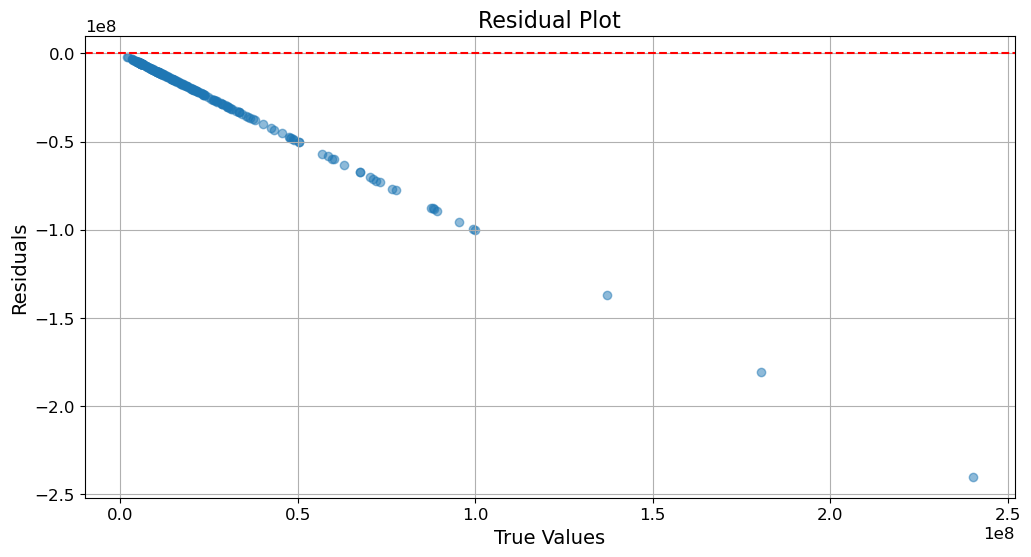

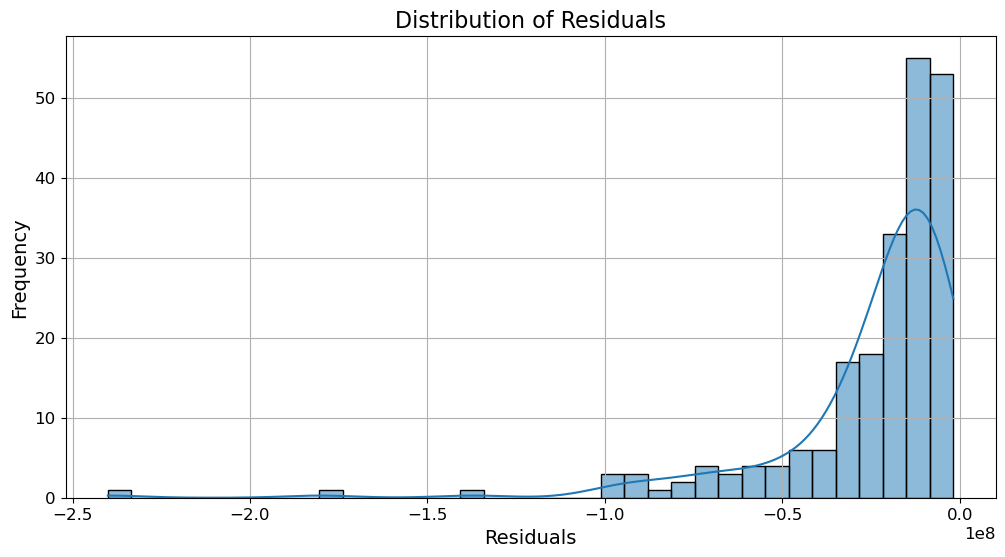

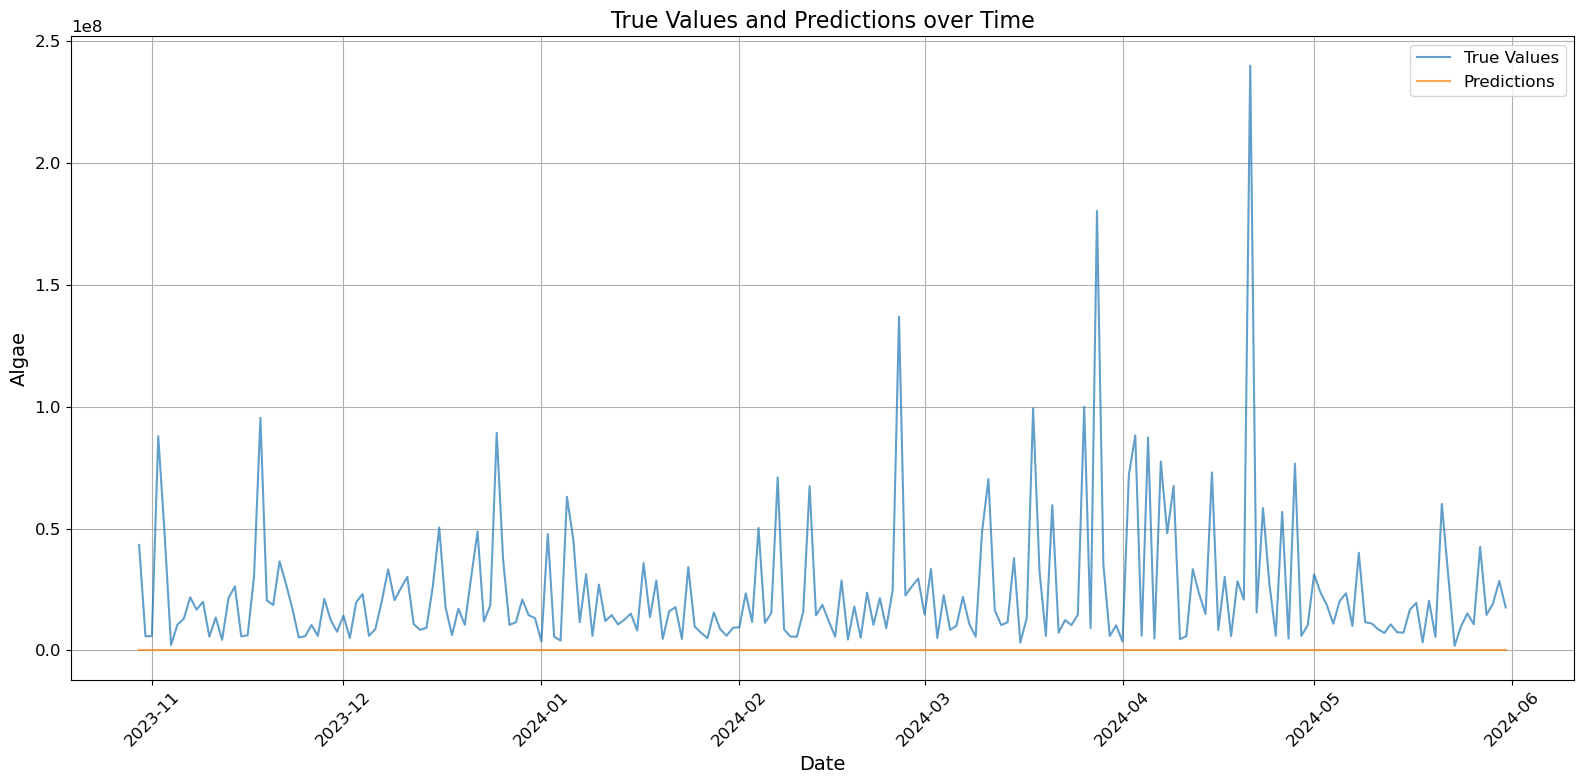

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 35 and the array at index 1 has size 215

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np

# 设置图表风格
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 1. 预测值vs真实值散点图
plt.figure(figsize=(10, 10))
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.grid(True)
plt.show()

# 2. 残差图
residuals = predictions - true_values
plt.figure(figsize=(12, 6))
plt.scatter(true_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# 3. 残差分布直方图
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

# 4. 预测值和真实值的时间序列图
plt.figure(figsize=(16, 8))
plt.plot(df['date'].iloc[-len(true_values):], true_values, label='True Values', alpha=0.7)
plt.plot(df['date'].iloc[-len(predictions):], predictions, label='Predictions', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Algae')
plt.title('True Values and Predictions over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. 特征重要性图（使用相关系数作为代理）
feature_importance = pd.DataFrame({'feature': features, 'importance': np.abs(np.corrcoef(X_test, y_test)[0, 1:])})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (based on correlation)')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# 6. 模型性能指标
r2 = r2_score(true_values, predictions)

performance_metrics = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R-squared'],
    'Value': [mse, rmse, mae, r2]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Value', data=performance_metrics)
plt.title('Model Performance Metrics')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

# 打印性能指标
print(performance_metrics)

# 7. 预测误差随时间变化图
plt.figure(figsize=(16, 8))
plt.plot(df['date'].iloc[-len(residuals):], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.title('Prediction Error over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()